In [301]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt


from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from nltk.stem import PorterStemmer


from sklearn.model_selection import train_test_split

import os
from wordcloud import WordCloud
from PIL import Image

from sklearn.utils import resample


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


#https://github.com/briannalytle/reddit_nlp/blob/master/EDA.ipynb


[nltk_data] Downloading package stopwords to C:\Users\Alberto
[nltk_data]     Vilas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Alberto
[nltk_data]     Vilas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [302]:
df = pd.read_csv("reddit_new_submissions.csv")
print(df.head(2))

                                               title          time  \
0  Flex fans, how do you feel about the newest ad...  1600189218.0   
1  [For Hire] - 3D Characters and Low Poly style ...  1600189218.0   

  description num_comments num_upvotes upvote_ratio  link_flair   nsfw  \
0         NaN            0           1          1.0         NaN  False   
1         NaN            0           1          1.0  [For Hire]  False   

   subreddit_title      redditor  \
0    Ask Reddit...      MANINIMO   
1  Art Commissions  LucasSouza01   

                                                 url  
0  https://www.reddit.com/r/AskReddit/comments/it...  
1                https://i.redd.it/6oi0lxvjecn51.jpg  


In [303]:
df.drop_duplicates(subset=['title','subreddit_title'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9916 entries, 0 to 10100
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            9916 non-null   object
 1   time             9916 non-null   object
 2   description      2882 non-null   object
 3   num_comments     9916 non-null   object
 4   num_upvotes      9916 non-null   object
 5   upvote_ratio     9916 non-null   object
 6   link_flair       3042 non-null   object
 7   nsfw             9916 non-null   object
 8   subreddit_title  9508 non-null   object
 9   redditor         9916 non-null   object
 10  url              9916 non-null   object
dtypes: object(11)
memory usage: 929.6+ KB


In [304]:
df.shape

(9916, 11)

Convert target to binary

In [305]:
df['nsfw'] = [1 if n=='True' else 0 for n in df.nsfw]

In [306]:
df['nsfw'].value_counts()

0    7338
1    2578
Name: nsfw, dtype: int64

In [307]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9916 entries, 0 to 10100
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            9916 non-null   object
 1   time             9916 non-null   object
 2   description      2882 non-null   object
 3   num_comments     9916 non-null   object
 4   num_upvotes      9916 non-null   object
 5   upvote_ratio     9916 non-null   object
 6   link_flair       3042 non-null   object
 7   nsfw             9916 non-null   int64 
 8   subreddit_title  9508 non-null   object
 9   redditor         9916 non-null   object
 10  url              9916 non-null   object
dtypes: int64(1), object(10)
memory usage: 929.6+ KB


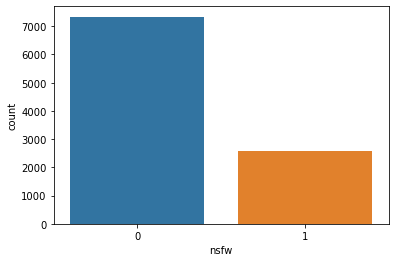

In [308]:
sns.countplot(x='nsfw', data=df)

Replace NaN with ' ', because it's necessary for df.title + df.description

Because tittle + description is a better field 


In [309]:
df['description']=df['description'].replace(np.nan, " ")
df['all_text'] = df['title'] + df['description']
df.head()

,title,time,description,num_comments,num_upvotes,upvote_ratio,link_flair,nsfw,subreddit_title,redditor,url,all_text
0,"Flex fans, how do you feel about the newest ad...",1600189218.0,,0,1,1.0,NaN,0,Ask Reddit...,MANINIMO,https://www.reddit.com/r/AskReddit/comments/it...,"Flex fans, how do you feel about the newest ad..."
1,[For Hire] - 3D Characters and Low Poly style ...,1600189218.0,,0,1,1.0,[For Hire],0,Art Commissions,LucasSouza01,https://i.redd.it/6oi0lxvjecn51.jpg,[For Hire] - 3D Characters and Low Poly style ...
2,Lily Collins,1600189218.0,,0,1,1.0,NaN,0,Elite Celebs,Mn_222,https://i.redd.it/hai4innkecn51.jpg,Lily Collins
3,The office go brrrr,1600189218.0,,0,1,1.0,NaN,0,People Person's Paper People,CapitalistUSSR,https://i.redd.it/am4dzl7lecn51.jpg,The office go brrrr
4,Am I curvy enough for you? [OC],1600189218.0,,1,1,1.0,Unverified OC,1,"/r/curvy: Buxom babes, voluptuous vixens, curv...",ElectraLovexx,https://i.redd.it/rgref9blecn51.jpg,Am I curvy enough for you? [OC]


In [310]:
df.groupby(['nsfw']).describe()

title                                                                 \
     count unique                                                top freq   
nsfw                                                                        
0     7338   7134                                 “Axial Precession”   10   
1     2578   1986  Kate <3 FREE ALBUM with videos and pics => jus...   27   

      time                           description         ...       redditor  \
     count unique           top freq       count unique  ...            top   
nsfw                                                     ...                  
0     7338   1240  1600303906.0   37        7338   2602  ...    couponifier   
1     2578   1057  1600304241.0    7        2578    226  ...  ashleywhite55   

            url                                                            \
     freq count unique                                                top   
nsfw                                                                        
0     228  7338   7189                       https://youtu.be/SDT2jLzFAxE   
1     162  2578   2234  https://redgifs.com/watch/leafyimprobableameri...   

          all_text                                                            \
     freq    count unique                                                top   
nsfw                                                                           
0       8     7338   7154                                “Axial Precession”    
1      18     2578   1990  Kate <3 FREE ALBUM with videos and pics => jus...   

           
     freq  
nsfw       
0      10  
1      27  

[2 rows x 44 columns]

# Clean Data


In [311]:
#Remove punctuacion and special characters based on pattern using RegEx

#remove punctuation and special characters
tokenizer = RegexpTokenizer(r'\w+')


df['all_text'] = df['all_text'].apply(lambda  x: tokenizer.tokenize(x.lower()))

df["all_text"].head()

0    [flex, fans, how, do, you, feel, about, the, n...
1    [for, hire, 3d, characters, and, low, poly, st...
2                                      [lily, collins]
3                             [the, office, go, brrrr]
4                 [am, i, curvy, enough, for, you, oc]
Name: all_text, dtype: object

# Remove Stop Words


In [312]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [313]:
df['all_text'] = df['all_text'].apply(lambda  x: remove_stopwords(x))

# Stemming & Lemmatizing

In [314]:
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem

stemmer = PorterStemmer()

def word_stemmer(text):
    stem = " ".join([stemmer.stem(i) for i in text])
    return stem

In [315]:
df['all_text_l'] = df['all_text'].apply(lambda  x: word_lemmatizer(x))
df['all_text_s'] = df['all_text'].apply(lambda  x: word_stemmer(x))

print(df['all_text_s'])

0        flex fan feel newest addit flex seal famili pr...
1        hire 3d charact low poli style start 60 dm int...
2                                              lili collin
3                                           offic go brrrr
4                                          curvi enough oc
                               ...                        
10096    naughti girl punish mistress made make free to...
10097    lost tome silver unfad flower megathread septe...
10098                       virgin peni ach pussi 7 5 inch
10099                                       2012 flashback
10100                                      stop meme queem
Name: all_text_s, Length: 9916, dtype: object


# Word Cloud Visualization

In [316]:
df_sfw = df[df.nsfw==0]
df_nsfw = df[df.nsfw==1]

def create_word_cloud(df):
    """
        Word cloud requires input of string
    """
    df_list = df['all_text_l'].tolist()
    df_string = ("").join(df_list)
    
    wordcloud = WordCloud(max_font_size = 50, max_words=50, margin=0, background_color = "white", colormap="Reds").generate(df_string)

    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    


Word Cloud - nsfw

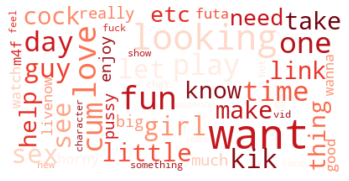

In [317]:
create_word_cloud(df_nsfw)

Word Cloud - sfw

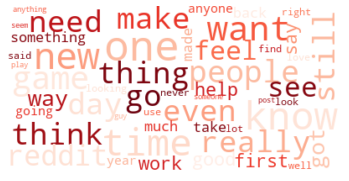

In [318]:
create_word_cloud(df_sfw)

# Handle imbalanced datasets

In [319]:
n_samples_nsfw = len(df_nsfw)
df["nsfw"].value_counts()


0    7338
1    2578
Name: nsfw, dtype: int64

In [320]:
# Down-sample Majority Class

df_sfw_downsampled = resample(df_sfw, 
                                 replace=False,    # sample without replacement
                                 n_samples=n_samples_nsfw,     # to match minority class
                                 random_state=0)

df_downsampled = pd.concat([df_sfw_downsampled, df_nsfw])
df_downsampled.nsfw.value_counts()

1    2578
0    2578
Name: nsfw, dtype: int64

# Split train and test data

In [321]:
#define target var
y=df_downsampled['nsfw']

X_train, X_test, y_train, y_test = train_test_split(df_downsampled['all_text_l'], y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4124,) (4124,)
(1032,) (1032,)


# Tf-IDF Vectorizer

In [322]:
#Naives bayes requires Tf-IDF vectors

x_lst = X_train.tolist()
y_lst = y_test.tolist()
vectorizer = TfidfVectorizer()
vetor_train_transformed = vectorizer.fit_transform(x_lst) #gives tf idf vector for x_train
vetor_test_transformed  = vectorizer.transform(X_test) #gives tf idf vector for x_test

# Fit/Train Model

## Naives Bayes

In [323]:
model = MultinomialNB()
model.fit(vetor_train_transformed, y_train)

MultinomialNB()

In [324]:
pred = model.predict(vetor_test_transformed)

In [325]:
def validation(y_lst,pred):
    matrix = confusion_matrix(y_lst, pred)
    print('Confusion Matrix :')
    sns.heatmap(matrix, annot=True)
    print ('Accuracy Score :',accuracy_score(y_lst, pred))
    print ('Report : ')
    print (classification_report(y_lst, pred) )
    score_2 = f1_score(y_lst, pred, average = 'binary')
    print('F-Measure: %.3f' % score_2)

Confusion Matrix :
Accuracy Score : 0.8546511627906976
Report : 
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       518
           1       0.84      0.87      0.86       514

    accuracy                           0.85      1032
   macro avg       0.85      0.85      0.85      1032
weighted avg       0.86      0.85      0.85      1032

F-Measure: 0.856


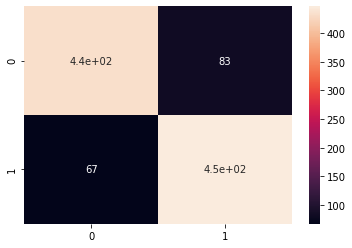

In [326]:
validation(y_lst,pred)